In [1]:
import os
os.getcwd()

'/Users/frankliang/Dropbox/Projects/Archieve/Covid-19/Python'

In [2]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt

## Calling API 
Refers to [Documentations for the API]( https://coronavirus.data.gov.uk/details/developers-guide#params-filters) for **structure** and **filter**. 
Change this part to select data:
```
query_filters = [
        f"areaType=nation"
    ]

    query_structure = {
        "date": "date",
        "name": "areaName",
        "code": "areaCode",
        "daily": "newCasesBySpecimenDate",
        "cumulative": "cumCasesBySpecimenDate"
    }
```
There is a dictionary of filter and list in website. 

In [3]:
from typing import Iterable, Dict, Union, List
from json import dumps
from requests import get
from http import HTTPStatus


StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]


def get_paginated_dataset(filters: FiltersType, structure: StructureType,
                          as_csv: bool = False) -> APIResponseType:
    """
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.

    as_csv: bool
        Return the data as CSV. [default: ``False``]

    Returns
    -------
    Union[List[StructureType], str]
        Comprehensive list of dictionaries containing all the data for
        the given ``filters`` and ``structure``.
    """
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": str.join(";", filters),
        "structure": dumps(structure, separators=(",", ":")),
        "format": "json" if not as_csv else "csv"
    }

    data = list()

    page_number = 1

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = get(endpoint, params=api_params, timeout=10)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        if as_csv:
            csv_content = response.content.decode()

            # Removing CSV header (column names) where page 
            # number is greater than 1.
            if page_number > 1:
                data_lines = csv_content.split("\n")[1:]
                csv_content = str.join("\n", data_lines)

            data.append(csv_content.strip())
            page_number += 1
            continue

        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    if not as_csv:
        return data

    # Concatenating CSV pages
    return str.join("\n", data)


if __name__ == "__main__":
    query_filters = [
        f"areaType=region"
    ]

    query_structure = {
        "date": "date",
        "name": "areaName",
        "code": "areaCode",
        "daily": "newCasesBySpecimenDate",
        "cumulative": "cumCasesBySpecimenDate"
    }

    json_data = get_paginated_dataset(query_filters, query_structure)
    print("JSON:")
    print(f"Length:", len(json_data))
    print("Data (first 3 items):", json_data[:3])

    print("---" * 10)
    
    csv_data = get_paginated_dataset(query_filters, query_structure, as_csv=True)
    csv_lines = csv_data.split("\n")
    print("CSV:")
    print(f"Length:", len(csv_lines))
    print("Data (first 3 lines):", csv_lines[:3])

JSON:
Length: 3513
Data (first 3 items): [{'date': '2021-03-15', 'name': 'East Midlands', 'code': 'E12000004', 'daily': 0, 'cumulative': 314815}, {'date': '2021-03-14', 'name': 'East Midlands', 'code': 'E12000004', 'daily': 156, 'cumulative': 314815}, {'date': '2021-03-13', 'name': 'East Midlands', 'code': 'E12000004', 'daily': 349, 'cumulative': 314659}]
------------------------------
CSV:
Length: 3514
Data (first 3 lines): ['date,name,code,daily,cumulative', '2021-03-15,East Midlands,E12000004,0,314815', '2021-03-14,East Midlands,E12000004,156,314815']


In [5]:
df = pd.DataFrame(json_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513 entries, 0 to 3512
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        3513 non-null   object
 1   name        3513 non-null   object
 2   code        3513 non-null   object
 3   daily       3513 non-null   int64 
 4   cumulative  3513 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 137.4+ KB


In [6]:
df.groupby(["name"])["cumulative"].sum()

name
East Midlands               34261883
East of England             36486757
London                      68113284
North East                  22545537
North West                  70491660
South East                  52221925
South West                  22162980
West Midlands               43715098
Yorkshire and The Humber    45064814
Name: cumulative, dtype: int64

In [7]:
df["date"] = pd.to_datetime(df["date"])

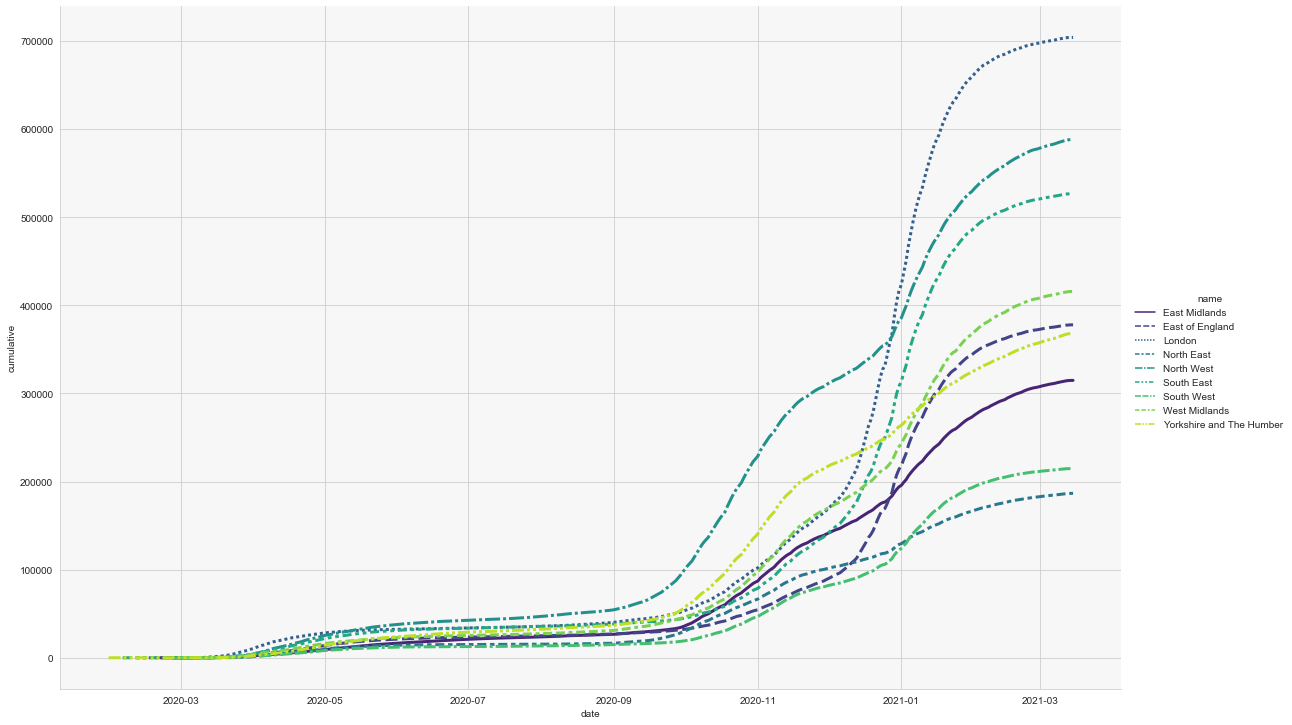

In [8]:
ic = sns.color_palette("icefire", as_cmap = True)

sns.set_style("whitegrid",{"axes.facecolor": "0.97"})
sns.relplot(height = 10,aspect=13/8.27,
            palette = "viridis",style = "name", linewidth = 3,
            kind = "line", data = df, x = "date", y = "cumulative", 
            hue = "name")

In [15]:
df.index = df["date"]
df["ref_date"] = df["date"] - df["date"].min()
df.index = df["ref_date"]

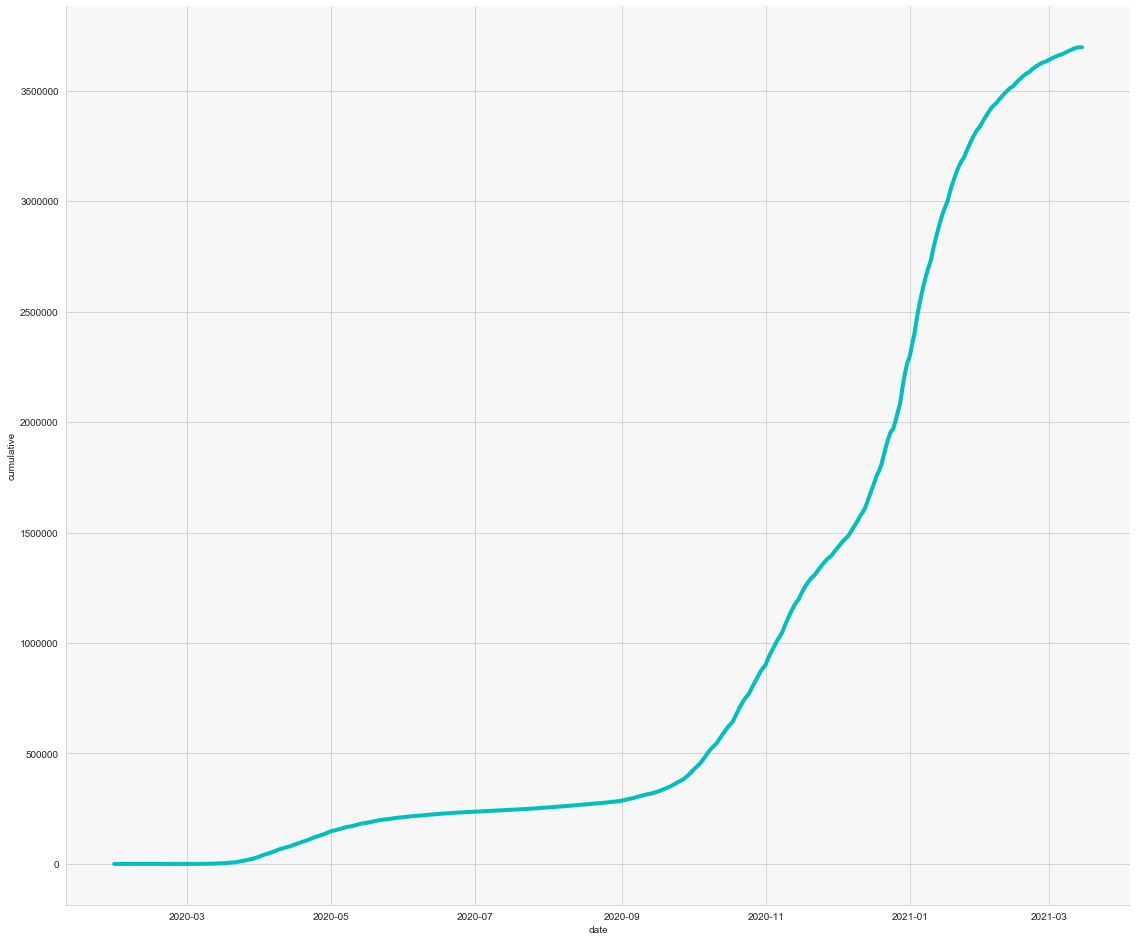

In [16]:
cum = df.groupby(["date"])["cumulative"].sum()
cum = pd.DataFrame(cum)



sns.set_style("whitegrid",{"axes.facecolor": "0.97"})
g = sns.relplot(kind = "line", color = "c",
           data = cum,linewidth = 4,
           x = "date",
           y = "cumulative",
               height = 13,aspect=10/8.27,)